# Naive Bayes Classifier - Implementation from scratch 
The notbook contains the code to implement the Naive Bayes Classifier from Scratch. 
It then compares the results with the output from sklearn library to ensure correctness of implementation.

### Importing required libraries

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from scipy.special import logsumexp
import re
from matplotlib import pyplot as plt

### Importing the dataset
- This dataset is taken from a **POC undertaken by Microsoft (Commercial Software Engineering team) in collaboration with Endava** to pre-classify IT support tickets in to ticket_type, urgency, impact etc.
- The data is anaonymized for privacy reasons and is made available for analysis.
- For our purpose, we will **classify the support tickets** in to **ticket types** which is a **binary outcome**
- The sample records of the dataset, and the category distribution is shown below

In [73]:
inp_dataset = pd.read_csv("all_tickets_binary.csv")
inp_dataset["ticket_type"] = inp_dataset["ticket_type"].astype("str")
inp_dataset.head(2)

,body,ticket_type
0,hi since recruiter lead permission approve req...,1
1,icon dear please setup icon per icon engineers...,1


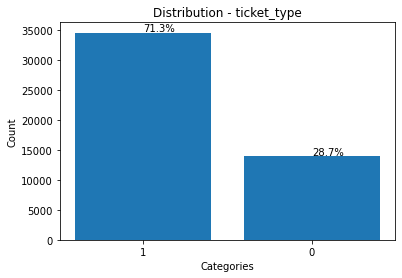

In [76]:
Cat_Count_df = inp_dataset.ticket_type.value_counts().reset_index() 
Cat_Count_df["Percentage"] = Cat_Count_df["ticket_type"]/Cat_Count_df["ticket_type"].sum()*100
plt.bar(Cat_Count_df["index"], Cat_Count_df["ticket_type"])
plt.xticks(Cat_Count_df["index"])
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Distribution - ticket_type")
for ind,row in Cat_Count_df.iterrows():
    plt.annotate(text=str(round(row["Percentage"],1))+"%",xy = (row["index"],row["ticket_type"]+300))

plt.show()

### Cleaning the articles to remove the unwanted characters
- Given this is a raw implementation of the text classification process, for data cleaning we are only removing numbers, punctuations and special characters from text
- This is done using regular expressions in the function defined as **text_clean**.
- Finally, we are splitting the data in to train and test set using *sklearn's function* **train_test_split**
- Notice the number of records in original, training and testing dataset

In [77]:
def text_clean(text_series):
    text_series = text_series.str.lower()
    clean_1 = text_series.str.replace(r"[^a-zA-Z\s]","")
    clean_2 = clean_1.str.replace(r"\s+", " ")
    return clean_2

In [79]:
inp_dataset["Text_Clean"] = text_clean(inp_dataset["body"])

In [80]:
train_x, test_x, train_y, test_y = train_test_split(inp_dataset["Text_Clean"], 
                                                    inp_dataset["ticket_type"], 
                                                    test_size = 0.3, 
                                                    random_state = 8)

### Creating Bag of Words
- In this step we are creating a dataframe which has the count frequency of each word in each document
- This is done using *sklearn's* **CountVectorizer** function. We have **passed the argument stop_words as "english" so that the function can remove the english stop words on it's own**.
- The same CountVectorizer is also used for creating the count frequencies of Test dataset. Notice, while transforming test dataset we are using the method **transform** and **not fit_transform**
- Observe the sample records from the dataframe. The number 1 below abacus in record 4 indicates that the **word Abacus came once in this document**. 

**Note:**

- Since the number of unique words across all the documents are very high, all the words are not visible

In [92]:
Cnt_Vec = CountVectorizer(stop_words="english")
BOW_train = Cnt_Vec.fit_transform(train_x).toarray()
BOW_train_Df = pd.DataFrame(BOW_train, columns=Cnt_Vec.get_feature_names())
BOW_train_Df[:4]

,ab,abandon,abandoned,abbott,abbreviations,abc,abeam,abilities,ability,able,...,zion,zip,zipped,zipper,zipping,zone,zones,zoom,zooming,zori
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
BOW_test = Cnt_Vec.transform(test_x).toarray()
BOW_test_Df = pd.DataFrame(BOW_test, columns=Cnt_Vec.get_feature_names())
BOW_test_Df[:4]

,ab,abandon,abandoned,abbott,abbreviations,abc,abeam,abilities,ability,able,...,zion,zip,zipped,zipper,zipping,zone,zones,zoom,zooming,zori
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Merging BOW data frames with respective Categories
- To get the article category values along with the word frequency, we are merging the 2 datasets
- This is done because we will be implementing the Naive Bayes approach from scratch and not using sklearn's inbuilt functions

In [98]:
BOW_train_Df["Category_Values"] = train_y.reset_index()["ticket_type"]
BOW_test_Df["Category_Values"] = test_y.reset_index()["ticket_type"]
BOW_train_Df.head(5)

,ab,abandon,abandoned,abbott,abbreviations,abc,abeam,abilities,ability,able,...,zip,zipped,zipper,zipping,zone,zones,zoom,zooming,zori,Category_Values
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Consolidating Bag of Words on the basis of Ticket_Type
- In this section we are grouping all the word frequencies on the basis of Ticket categories they fall in
- An additional column is added to the dataframe which contains the count of all the words across the documents in specific category
- The ArticleId column is having the count of articles in each category
- Refer to the sample records as shown below

In [128]:
Cons_df = BOW_train_Df.groupby("Category_Values",as_index = False).sum().reset_index(drop=True)
Category_Count_df = BOW_train_Df["Category_Values"].value_counts().reset_index()
Category_Count_df.columns = ["Category_Values", "Category_Count"]
Cons_df = pd.merge(Cons_df,Category_Count_df,on="Category_Values",how = "left")
Cons_df["sum_all_words"] = Cons_df.sum(axis = 1)

### Creating Probability Table
- Using the consolidated table we created in the previous section, we will now calculate the probabilities of each word occuring in each artcile category
- Laplace smoothing is also built in to ensure that words with 0 frequency are taken care of. This table will be used to calculate the probability of all the test documents
- See the sample dataframe output

In [155]:
Cons_df[1,"Category_Values"]

KeyError: (1, 'Category_Values')

In [160]:
col1 = [col for col in Cons_df.columns if Cons_df.loc[0,col] != 0]

In [161]:
len(col1)

7073

In [159]:
Cons_df

,Category_Values,ab,abandon,abandoned,abbott,abbreviations,abc,abeam,abilities,ability,...,zipped,zipper,zipping,zone,zones,zoom,zooming,zori,Category_Count,sum_all_words
0,0,29,0,7,0,0,3,1,0,37,...,1,2,0,151,1,1,1,0,9757,360989
1,1,0,3,4,1,1,3,0,7,79,...,2,4,1,479,11,9,0,1,24227,725477


In [146]:
alpha = 1
prob_table = pd.DataFrame()
prob_table["Category"] = Cons_df["Category_Values"]
prob_table["p_C"] = Cons_df["Category_Count"]/Cons_df["Category_Count"].sum()
cols = [col for col in Cons_df.columns if col not in ["Category_Values", "Category_Counts", "sum_all_words"]]
no_of_cols = len(cols)
for col in cols:
    prob_table[col] = (Cons_df[col]+alpha)/(Cons_df["sum_all_words"] + (alpha*no_of_cols))

In [147]:
prob_table.head()

,Category,p_C,ab,abandon,abandoned,abbott,abbreviations,abc,abeam,abilities,...,zip,zipped,zipper,zipping,zone,zones,zoom,zooming,zori,Category_Count
0,0,0.287106,0.000081,0.000003,0.000022,0.000003,0.000003,0.000011,0.000005,0.000003,...,0.000022,0.000005,0.000008,0.000003,0.000409,0.000005,0.000005,0.000005,0.000003,0.026248
1,1,0.712894,0.000001,0.000005,0.000007,0.000003,0.000003,0.000005,0.000001,0.000011,...,0.000024,0.000004,0.000007,0.000003,0.000652,0.000016,0.000014,0.000001,0.000003,0.032907


### Cross Checking the Probability Values using SKlearn
- Using the probability table creating in the previous section, the test dataset articles will be classified

In [138]:
BOW_train_Df["Category_Values"].value_counts()

1    24227
0     9757
Name: Category_Values, dtype: int64

In [168]:
BOW_train_Df

,ab,abandon,abandoned,abbott,abbreviations,abc,abeam,abilities,ability,able,...,zip,zipped,zipper,zipping,zone,zones,zoom,zooming,zori,Category_Values
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33979,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
33980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
33982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [148]:
MNB_Model = MultinomialNB(alpha=1)
model = MNB_Model.fit(BOW_train_Df.drop("Category_Values",axis = 1), train_y)

In [166]:
a = model.feature_count_+1

In [167]:
a.sum(axis=1)

array([362002., 712020.])

In [149]:
np.exp(model.feature_log_prob_)

array([[8.28724703e-05, 2.76241568e-06, 2.20993254e-05, ...,
        5.52483135e-06, 5.52483135e-06, 2.76241568e-06],
       [1.40445493e-06, 5.61781972e-06, 7.02227466e-06, ...,
        1.40445493e-05, 1.40445493e-06, 2.80890986e-06]])